In [1]:
from utils import process_data, print_wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from corextopic import corextopic as ct

In [2]:
# Load and preprocesss reviews.
reviews_df        = pd.read_csv('data/reviews.csv')
processed_df      = process_data(reviews_df, 'Reviews', path='data/processed_reviews.csv')
processed_reviews = processed_df['processed_Reviews'].tolist()

In [3]:
# Create TF-IDF document term matrix.
tfidf = TfidfVectorizer(
    max_df=.8,          # ignore words that appear in more than max_df % of documents
    min_df=1,           # ignore words that appear in less than min_df documents
    max_features=None,
    ngram_range=(1, 2),
    norm=None,
    binary=True,
    use_idf=False,
    sublinear_tf=False
)
tfidf = tfidf.fit(processed_reviews)
dtm   = tfidf.transform(processed_reviews)
vocab = tfidf.get_feature_names()

In [4]:
# Set anchors. An empty list allows freedom to the model for that topic.
anchors = [
    ['space'],
    ['horror', 'zombie'],
    []
]
n_topics = len(anchors)

In [5]:
# Create and fit CorEx model.
model = ct.Corex(n_hidden=n_topics, seed=42)
model = model.fit(
    dtm,
    words=vocab,
    anchors=anchors,
    anchor_strength=5  # Tell the model how much it should rely on the anchors
)

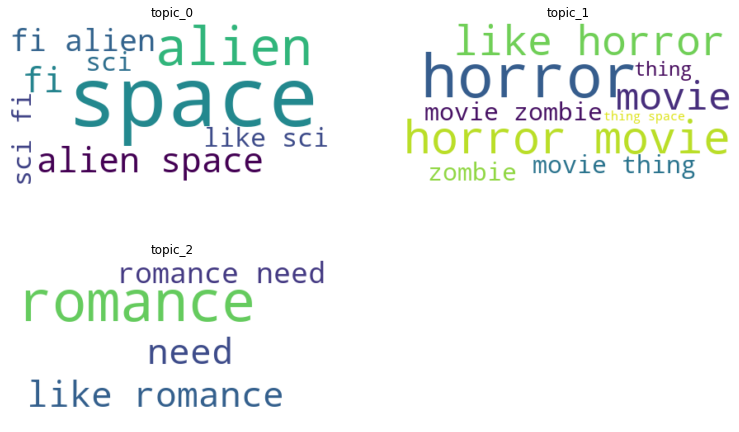

In [6]:
# Plot Word Clouds with top-10 words per topic.
plt.figure(figsize=(13, 4 * np.ceil(n_topics / 2.)))

for index, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    top_words = [ngram[0]       for ngram in topic_ngrams if ngram[1] > 0]
    scores    = [100 * ngram[1] for ngram in topic_ngrams if ngram[1] > 0]
    
    print_wordcloud(top_words, scores, index, f'topic_{index}', n_topics)

plt.show()

In [7]:
# Dump results to file.
topic_df = pd.DataFrame(
    model.transform(dtm), 
    columns=[f'topic_{i}' for i in range(n_topics)]
).astype(float)
topic_df.index = reviews_df.index
results = pd.concat([reviews_df, topic_df], axis=1)
results.to_csv(f'results/corex_predictions.csv', index=False)

In [8]:
results.head()

,Reviews,topic_0,topic_1,topic_2
0,I like horror movies with zombies.,0.0,1.0,0.0
1,I like horror movies and things from space.,1.0,1.0,0.0
2,I like romance.,0.0,0.0,1.0
3,I like sci-fi with aliens in space.,1.0,0.0,0.0
4,Romance is all I need!,0.0,0.0,1.0
